# Instagram Posts - Text Classification with FastText

**FastText** is a library implemented by Facebook for word representation learning and text classification. It is based on the idea that linear models with a rank constraint and a fast loss approximation can train on a billion words within ten minutes, while achieving performance on par with the state-of-the-art. Therefore, over the several methods for text classification, FastText has the advantage of being much faster, while achieving high accuracies. In particular, FastText creates word representations which are then averaged into a text representation. This text representation, is in turn fed to a linear classifier with an specific loss function.

**Source**: Armand Joulin et al. “Bag of Tricks for Efficient Text Classification”. In: CoRR abs/1607.01759 (2016). URL:
http://arxiv.org/abs/1607.01759.


The following information is in relation of the data we are are required for being used by FastText:

* The train_data.txt file contains all the instagram post tags (around 1 million and a half instagram posts) that we collected from the different json files that are in the cluster and that already have a sentiment (which we write as a "label"). The structure is the following:

**\__label__"insert label here" "instagram post tags"**

Where "insert label here" has to be replaced by the corresponding sentiment:
"1" for positive
"0" for neutral
"-1" for negative

For example,

**\__label__1 Ambulance Basel Bern Feuerwehr Polizei Schweiz Super_Switzerland Swiss Switzerland Switzerland_Vacations ig_switzerland inlovewithswitzerland rbs_ch sbbcffffs switzerlandpictures visitswitzerland worldunion wu_switzerland**


* The test_data.txt file contains all the instagram post tags (around 6 million and a half instagram posts) that have to be predicted by the FastText model created upon the train data. The structure is the following:

**instagram_post_id, "instagram post tags"**

For example,

**1459540901000011138,aargau ag art baden badencity badencityaargau badenist badenschweiz city igersaargau igersbaden igersschweiz igerssuisse igersswiss igersswitzerland igswiss instagramer instaswiss iphone iphone5 picoftheday schweiz suisse svizzera swiss switzerland wu_switzerland**

**NOTE:** this code corresponds to a **<span style="color:red">bash code and has to be run in the terminal</span>** (it was tested on MacOs). We chose this because we found it much faster than using python.

**NOTE:** there has to be a "data" folder with the corresponding files for training/testing. These files have to be named as train_data.txt and test_data.txt and the way to get those files is by running our script "get_fasttext_format.py" (check scripts folder) in the cluster. the files are not available in this repository since they exceed the 100MB per file that GitHub limits. (The test file is about 1 GB and the train file is about 350 MB)


```
clear
mkdir proc
mkdir results
mkdir cross_validation
mkdir confusion_matrix
mkdir feature_analysis

#Preparing the data to be processed by FastText by:
        #getting all characters to lowercase
        #deleting all double blank spaces
echo "Loading train_data..."
cat data/train_data.txt | tr '[:upper:]' '[:lower:]' | tr -s '[:space:]' > proc/train_data_FT.txt
echo "Getting the ids"
cat data/test_data.txt | sed -e 's/[,].*//' > proc/ids_test.txt
echo "Loading test data..."
cat data/test_data.txt | tr '[:upper:]' '[:lower:]' | tr -s '[:space:]' | sed -e 's/^[^,]*,//' >  proc/test_data.txt
```

After this processing, we obtain the files (in a new folder "proc") that are going to be used to build the classifier

* **train_data_FT.txt:** it is the same train_data.txt file but in lower case and with only single spaces.
* **ids_test.txt:** Contains all the ids of the instagram posts in order to keep a record of id-sentiment after the classification.
* **test_data.txt:** it is the same test_data.txt but in lower case, only single spaces and without the ids.

**Please note that FastText runs with .txt files** and that we are not doing any other processing to the text other than getting everything in lower-case and removing all the the double blank spaces. This is because as we are using the instagram tags, they are already key-words that are going to belong to the bag of words. As we know, there are several languages in the tags, but mostly in english, but since we are using supervised classification, each of the words will have its own weight related to the respective label.


In [15]:
import csv
import fasttext
import numpy as np
import random
import os
from sklearn.metrics import confusion_matrix
from PIL import Image
import nltk
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline 

### Feature analysis

Let's analize the train data we have, first by separating each of the labels (sentiments), this in order to be analized separately.

For doing this we can run the following bash code:

```
#Positive instagram posts
cat proc/train_data_FT.txt | sed '/^__label__-1/ d'| sed '/^__label__0/ d' | sed -e 's/^.*__label__1 //g' > feature_analysis/positive_posts.txt

#Neutral instagram posts
cat proc/train_data_FT.txt | sed '/^__label__1/ d'| sed '/^__label__-1/ d' | sed -e 's/^.*__label__0 //g' > feature_analysis/neutral_posts.txt

#Negative instagram posts
cat proc/train_data_FT.txt | sed '/^__label__1/ d'| sed '/^__label__0/ d' | sed -e 's/^.*__label__-1 //g' > feature_analysis/negative_posts.txt

```

In [2]:
positive_dir="feature_analysis/positive_posts.txt"
negative_dir="feature_analysis/negative_posts.txt"
neutral_dir="feature_analysis/neutral_posts.txt"
#Reading the created files
#Positive
fin=open(positive_dir,'r')
positive_data=fin.read().splitlines()
fin.close()

fin=open(positive_dir,'r')
positive_data_1_line=fin.read().replace('\n',' ')
fin.close()

#Neutral
fin=open(neutral_dir,'r')
neutral_data=fin.read().splitlines()
fin.close()

fin=open(neutral_dir,'r')
neutral_data_1_line=fin.read().replace('\n',' ')
fin.close()

#Negative
fin=open(negative_dir,'r')
negative_data=fin.read().splitlines()
fin.close()

fin=open(negative_dir,'r')
negative_data_1_line=fin.read().replace('\n',' ')
fin.close()

In [120]:
total_posts=len(positive_data)+len(neutral_data)+len(negative_data)
print("Total number of instagram posts: %d" % total_posts)

Total number of instagram posts: 1504278


In [121]:
#Let's see how many instagram posts we have for each sentiment:
print("Number of positive posts: %d" %len(positive_data))
print("Number of neutral posts: %d" %len(neutral_data))
print("Number of negative posts: %d" %len(negative_data))

Number of positive posts: 1082705
Number of neutral posts: 349152
Number of negative posts: 72421


In [123]:
#Let's see the previous numbers in percentage:
print("Positive posts: %0.2f%%" %(len(positive_data)*100/total_posts))
print("Neutral posts: %0.2f%%" %(len(neutral_data)*100/total_posts))
print("Negative posts: %0.2f%%" %(len(negative_data)*100/total_posts))

Positive posts: 71.98%
Neutral posts: 23.21%
Negative posts: 4.81%


As we can see, there is a notorious majority in the positive instagram posts, as well a very less percentage both for neutral and negative posts.

In [3]:
#Let's get know the most common words for each label
positive_words=nltk.word_tokenize(positive_data_1_line)
neutral_words=nltk.word_tokenize(neutral_data_1_line)
negative_words=nltk.word_tokenize(negative_data_1_line)

In [4]:
fdist_positive=nltk.FreqDist(positive_words)
fdist_negative=nltk.FreqDist(negative_words)
fdist_neutral=nltk.FreqDist(neutral_words)

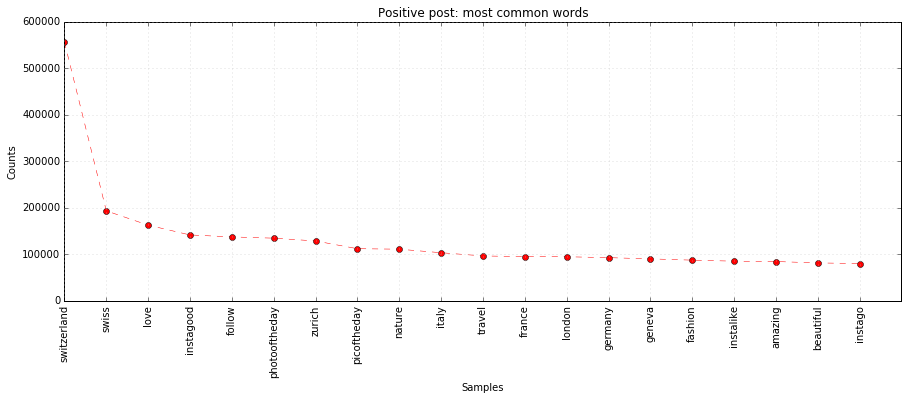

In [147]:
#Let's plot the most common 20 words for each sentiment
plt.figure(figsize=(15,5))
fdist_positive.plot(20,cumulative=False,title="Positive post: most common words",
                    color='r',marker='o',linestyle='--',linewidth=0.5)

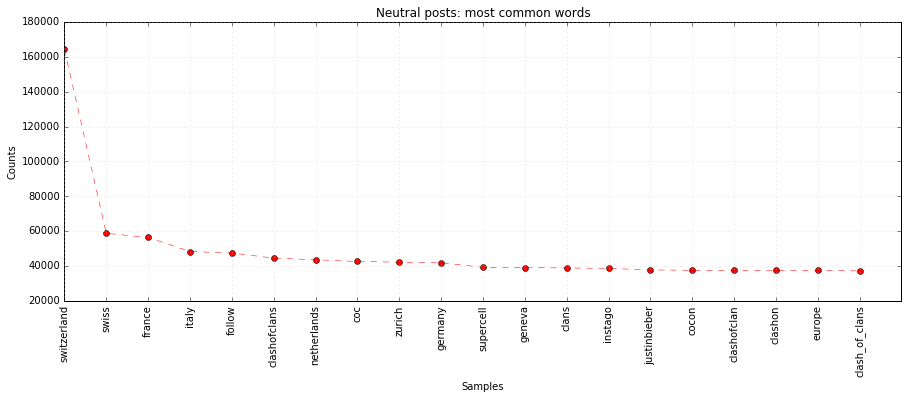

In [148]:
plt.figure(figsize=(15,5))
fdist_neutral.plot(20,cumulative=False,title="Neutral posts: most common words",
                   color='r',marker='o',linestyle='--',linewidth=0.5)

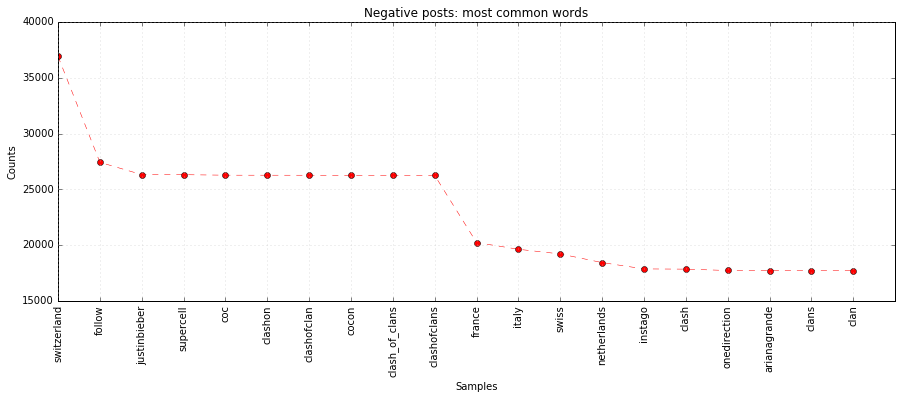

In [149]:
plt.figure(figsize=(15,5))
fdist_negative.plot(20,cumulative=False,title="Negative posts: most common words",
                   color='r',marker='o',linestyle='--',linewidth=0.5)

As expected, the most frequent word in the three sentiments is "Switzerland" along with some swiss cities such as Geneva, Zurich. Since we are going to use bi-grams (as explained in the following section), we don't want to remove those words since the combination could give us a better result.

Finally, let's create wordclouds with the words we found

In [153]:
#Defining a mask with the form of Switzerland for showing the wordcloud
swiss_mask=np.array(Image.open("mapCH.png"))

(-0.5, 4722.5, 2987.5, -0.5)

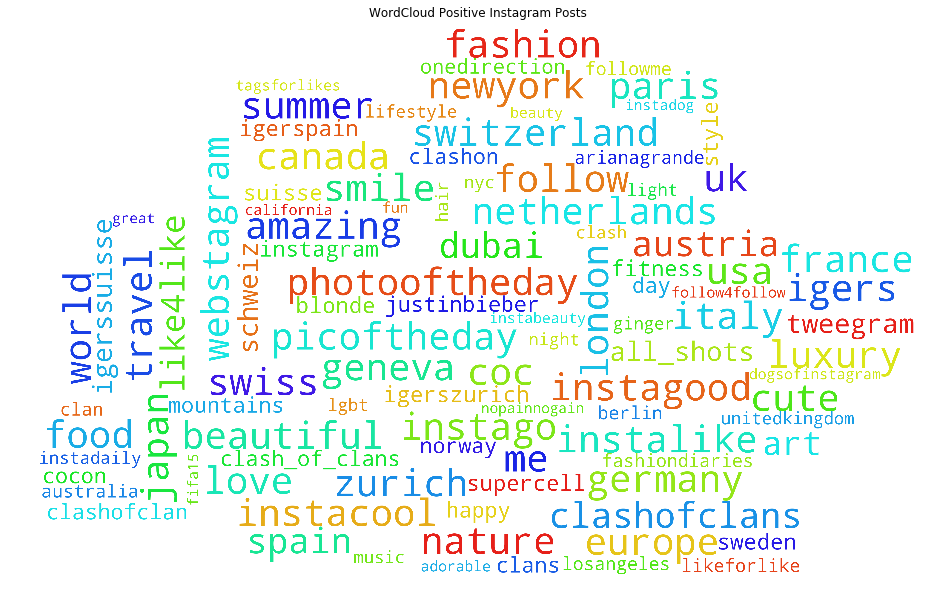

In [159]:
WordCloud_positive = WordCloud(background_color="white", max_words=100
                               , mask=swiss_mask).fit_words(fdist_positive.most_common(100))
plt.figure(figsize=(20,10))
plt.imshow(WordCloud_positive)
plt.title('WordCloud Positive Instagram Posts')
plt.axis("off")

(-0.5, 4722.5, 2987.5, -0.5)

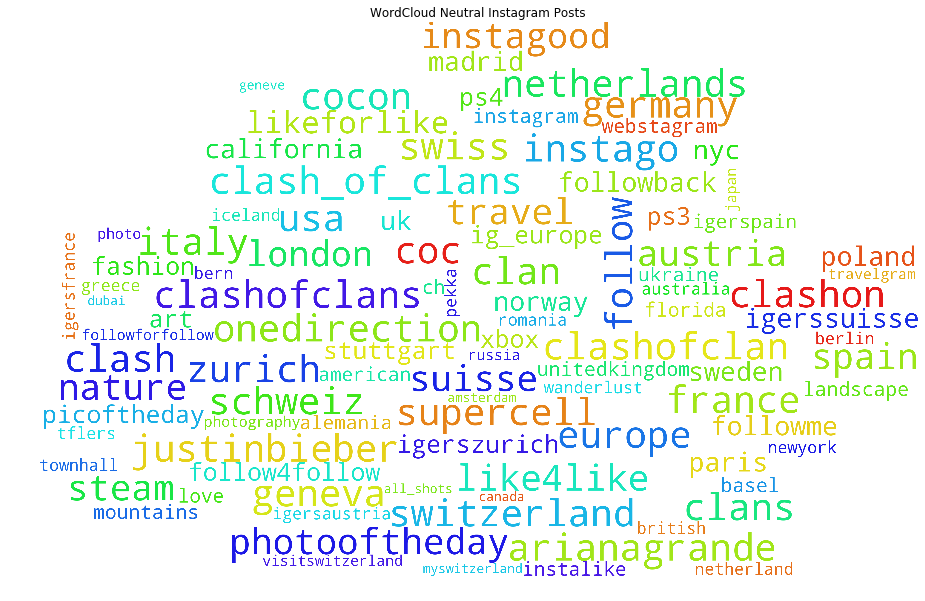

In [160]:
WordCloud_neutral = WordCloud(background_color="white", max_words=100
                               , mask=swiss_mask).fit_words(fdist_neutral.most_common(100))
plt.figure(figsize=(20,10))
plt.imshow(WordCloud_neutral)
plt.title('WordCloud Neutral Instagram Posts')
plt.axis("off")

(-0.5, 4722.5, 2987.5, -0.5)

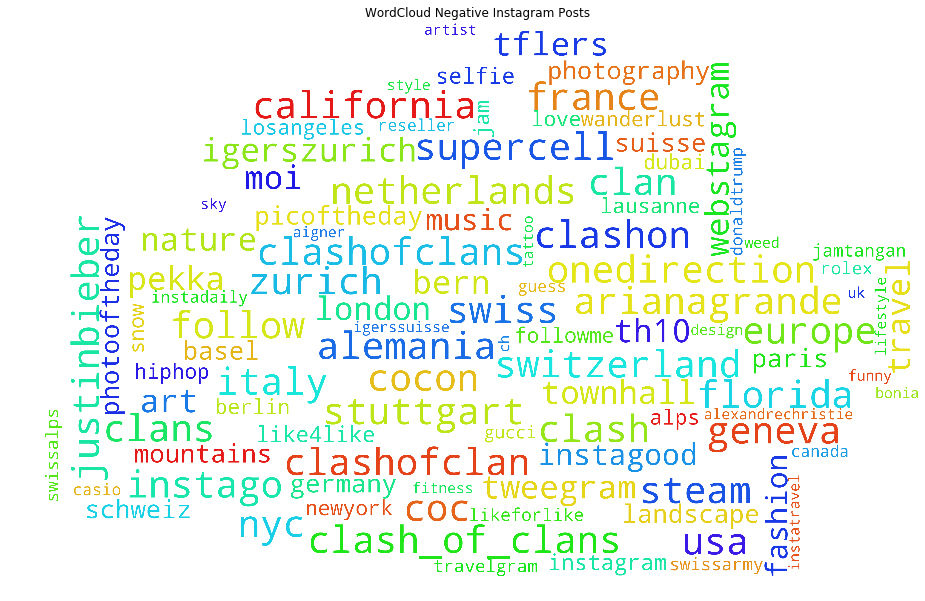

In [161]:
WordCloud_negative = WordCloud(background_color="white", max_words=100
                               , mask=swiss_mask).fit_words(fdist_negative.most_common(100))
plt.figure(figsize=(20,10))
plt.imshow(WordCloud_negative)
plt.title('WordCloud Negative Instagram Posts')
plt.axis("off")

It is interesting that even though the instagram posts are about Switzerland, most the most common words for the three sentiments have nothing to do with Switzerland: words mentioning other countries, artists, some random words, but on the other hand, we can find several words that are (or could be) related to Switzerland, such as:
* switzerland
* swissalps
* schweiz
* mountains
* basel
* snow
* suisse
* travel
* rolex
* swissarmy
* zurich
* geneva
* visitswitzerland

However, we also have to think of the fact that one instagram post could have so many tags, and most of them have nothing to do with the picture they are posting.

Let's now get the common words and the ratios of them between the three sentiments so that we can try to delete some of them before trying to train the model. For example, we saw that the word "switzerland" is present in the three sentiment posts, but it has a different number of occurrences in each of them:

In [10]:
print("Number of ocurrences for 'switzerland' in the positive posts: %d" % fdist_positive['switzerland'])
print("Number of ocurrences for 'switzerland' in the negative posts: %d" % fdist_negative['switzerland'])
print("Number of ocurrences for 'switzerland' in the neutral posts: %d" % fdist_neutral['switzerland'])

Number of ocurrences for 'switzerland' in the positive posts: 556610
Number of ocurrences for 'switzerland' in the negative posts: 36903
Number of ocurrences for 'switzerland' in the neutral posts: 164225


In [14]:
#Now we can get the ratio between them, because even though the word is in the three sentiment posts, 
#the number of occurrences in the positive posts is much higher, so we cannot delete it.
print("Ratio (positive/neutral) for the word 'switzerland' %0.2f" % (fdist_positive['switzerland']/fdist_neutral['switzerland']))
print("Ratio (positive/negative) for the word 'switzerland' %0.2f" % (fdist_positive['switzerland']/fdist_negative['switzerland']))
print("Ratio (neutral/neegative) for the word 'switzerland' %0.2f" % (fdist_neutral['switzerland']/fdist_negative['switzerland']))

Ratio (positive/neutral) for the word 'switzerland' 3.39
Ratio (positive/negative) for the word 'switzerland' 15.08
Ratio (neutral/neegative) for the word 'switzerland' 4.45


Like we can see in the results, even though the word is repeated in the three sentiment post the ratio in those is different, specially for the positive-negative posts which is 15.08, which means that for everytime the word appears in a negative post it appears in 15 positive posts, so we cannot discard it. 

Now we will do the same analysis for the most common 100 words presented in the three sentiment posts:

In [29]:
#Positive words
df_pos=pd.DataFrame.from_records(fdist_positive.most_common(1000),columns=['word','repetition'])
pos_words=df_pos.word

#Negative words
df_neg=pd.DataFrame.from_records(fdist_negative.most_common(1000),columns=['word','repetition'])
neg_words=df_neg.word

#Neutral words
df_neu=pd.DataFrame.from_records(fdist_neutral.most_common(1000),columns=['word','repetition'])
neu_words=df_neu.word

In [30]:
#Getting the common words presented in the 3 sentiments
common_words_3_sentiments=set(neg_words) & set(pos_words) & set(neu_words)

In [33]:
#Getting the common words in a list
common_words_3_sentiments=list(common_words_3_sentiments)

In [34]:
print("There are %d common words presented in the three sentiments:\n" %len(common_words_3_sentiments))
print("Some of them are:")
print(common_words_3_sentiments[:20])

There are 470 common words presented in the three sentiments:

Some of them are:
['boys', 'boeing', 'watchoftheday', 'la', 'menswear', 'hiphop', 'gopro', 'igers', 'throwback', 'vscocam', 'pekka', 'reseller', 'lebanon', 'earth', 'uae', 'amazing', 'winter', 'tour', 'artwork', 'kinshasa']


In [35]:
#Now we are going the do the analysis for the most common 1000 words like we did for the word 'switzerland':
print("Getting list of common words presented in the thre sentiments...")
common_words_pos=[]
common_words_neg=[]
common_words_neu=[]
for i in range(len(common_words_3_sentiments)):
    #Getting the number of occurrences of the words 
    num_occurences_neg=df_neg.repetition[df_neg.word==common_words_3_sentiments[i]].get_values()[0]
    num_occurences_pos=df_pos.repetition[df_pos.word==common_words_3_sentiments[i]].get_values()[0]
    num_occurences_neu=df_neu.repetition[df_neu.word==common_words_3_sentiments[i]].get_values()[0]
    #Getting the ratios
    ratio_neg_pos=num_occurences_neg/num_occurences_pos
    ratio_neu_pos=num_occurences_neu/num_occurences_pos
    ratio_neu_neg=num_occurences_neu/num_occurences_neg
    
    #We have to set a threshold for the ratios, so that we can be sure that we have almost the same number of
    #words in the different posts (the ratio is from 0.95 to 1.05)
    
    #Positive-negative ratios
    if (ratio_neg_pos>=0.95 and ratio_neg_pos<=1.05):
        common_words_pos.append(common_words_3_sentiments[i])
        common_words_neg.append(common_words_3_sentiments[i])
        
    #Positive-neutral ratios
    if (ratio_neu_pos>=0.95 and ratio_neu_pos<=1.05):
        common_words_pos.append(common_words_3_sentiments[i])
        common_words_neu.append(common_words_3_sentiments[i])
        
    #Neutral-negative ratios
    if (ratio_neu_neg>=0.95 and ratio_neu_neg<=1.05):
        common_words_neu.append(common_words_3_sentiments[i])
        common_words_neg.append(common_words_3_sentiments[i])

#Displaying the common words for the three sentiments
        
if common_words_pos==[]:
    print("There are not common words in the positive posts")
else:
    print("Common words in the positive posts:")
    print(common_words_pos)
    print("\n")
    
if common_words_neg==[]:
    print("There are not common words in the negative posts")
else:
    print("Common words in the negative posts:")
    print(common_words_neg)
    print("\n")

if common_words_neu==[]:
    print("There are not common words in the neutral posts")
else:
    print("Common words in the neutral posts:")
    print(common_words_neu)

Getting list of common words presented in the thre sentiments...
Common words in the positive posts:
['pekka', 'bvlgari', 'tflers', 'alemania', 'townhall']


Common words in the negative posts:
['alemania', 'tweegram']


Common words in the neutral posts:
['pekka', 'bvlgari', 'tflers', 'tweegram', 'townhall']


From the 470 common words presented in the 3 sentiments, only 6 words meets with the **threshold (ratio between 0.95 and 1.05)**:

* pekka
* bvlgari
* tflers
* alemania
* townhall
* tweetgram


Finally, let's get the percentage of occurrence for those words (assuming they appear once in each post) when comparing to the total number in the instagram posts

In [50]:
print("Percentage of the occurrence for the word 'pekka' %0.4f%%" % 
      ((fdist_positive['pekka']+ fdist_neutral['pekka'])*100/total_posts))
print("Percentage of the occurrence for the word 'bvlgari' %0.4f%%" % 
      ((fdist_positive['bvlgari']+ fdist_neutral['bvlgari'])*100/total_posts))
print("Percentage of the occurrence for the word 'tflers' %0.4f%%" % 
      ((fdist_positive['tflers']+ fdist_neutral['tflers'])*100/total_posts))
print("Percentage of the occurrence for the word 'alemania' %0.4f%%" % 
      ((fdist_positive['alemania']+ fdist_negative['alemania'])*100/total_posts))
print("Percentage of the occurrence for the word 'townhall' %0.4f%%" % 
      ((fdist_positive['townhall']+ fdist_neutral['townhall'])*100/total_posts))
print("Percentage of the occurrence for the word 'pekka' %0.4f%%" % 
      ((fdist_negative['tweetgram']+ fdist_neutral['tweetgram'])*100/total_posts))

Percentage of the occurrence for the word 'pekka' 1.6741%
Percentage of the occurrence for the word 'bvlgari' 0.5002%
Percentage of the occurrence for the word 'tflers' 1.6257%
Percentage of the occurrence for the word 'alemania' 1.5008%
Percentage of the occurrence for the word 'townhall' 1.6723%
Percentage of the occurrence for the word 'pekka' 0.0052%


Since the percentage are too small compared to the whole train data set, and just for single words, we don't consider to remove them from our data set.

### Getting the parameters for FastText

In [58]:
#Defining the directories where the data is
train_data_dir='proc/train_data_FT.txt'
test_data_dir='proc/test_data.txt'
test_data_ids_dir='proc/ids_test.txt'

In [40]:
#Reading training data
with open(train_data_dir, encoding="utf-8") as d:
    all_insta_posts = d.readlines()

#Splitting the train data into train and test with a ratio of ratio_train in order to test the classifier locally
N = len(all_insta_posts)
ratio_train = 0.8
ind = random.sample(range(N),N)
ind_train=ind[1:int(N*ratio_train)+1]
ind_test = ind[int(N*ratio_train)+1:]
new_insta_posts = [all_insta_posts[e] for e in ind_train]
test_insta_posts =[all_insta_posts[e] for e in ind_test]

In [41]:
#Paths to collect splitted training data
train_data_dir_train='proc/sp_train_data_.txt'
train_data_dir_test='proc/sp_train_data_test.txt'

#Creating the new files from splitting the train data
with open(train_data_dir_train, "wb") as f:
    for item in new_insta_posts:
         f.write(bytes(item,'UTF-8'))

with open(train_data_dir_test, "wb") as f:
    for item in test_insta_posts:
        f.write(bytes(item,'UTF-8'))

In [47]:
#Defining some parameters

#Defining the possible loss functions:
loss_functions=["ns","hs","softmax"]
#Defining the possible learning rate values (gamma)
learning_rate_values=np.linspace(0,0.1,10)
#Defining the possible window size values
ws_values=[1,2,3,4,5]
#Defining the possible minimum word count value
min_count_values=[1,2,3,4,5]
#Defining the possible values for the n-grams
n_grams_values=[1,2,3,4,5]

#We will consider the next parameters as fixed
thread_val=4
bucket_val=2000000
epoch_val=5

In [43]:
#Let's first select the loss function more suitable for the model, let's let the other parameters with their default
#value
for i in range(len(loss_functions)):
    classifier = fasttext.supervised(train_data_dir_train, 'results/model',epoch=epoch_val, loss=loss_functions[i], 
                                 thread=thread_val,bucket=bucket_val)
    results=classifier.test(train_data_dir_test)
    print("Precision with %s: %f" % (loss_functions[i],results.precision))

Precision with ns: 0.850563
Precision with hs: 0.852982
Precision with softmax: 0.853757


In [48]:
#As we could see in the above cell, the loss function that gives us (slightly) better results is "softmax".

#Let's vary the learning rate.
precision_test_train=[]
precision_train=[]
for i in range(len(learning_rate_vals)):
    classifier = fasttext.supervised(train_data_dir_train, 'results/model',epoch=epoch_val,lr=learning_rate_values[i] ,loss="softmax", 
                                     thread=thread_val,bucket=bucket_val)
    results=classifier.test(train_data_dir_test)
    print("Precision with a learning rate of value %f [test]: %f" % (learning_rate_values[i], results.precision))
    precision_test_train.append(results.precision)
    results=classifier.test(train_data_dir_train)
    print("Precision with a learning rate of value %f [train]: %f" % (learning_rate_values[i], results.precision))
    precision_train.append(results.precision)

Precision with a learning rate of value 0.000000 [test]: 0.047927
Precision with a learning rate of value 0.000000 [train]: 0.048198
Precision with a learning rate of value 0.011111 [test]: 0.847515
Precision with a learning rate of value 0.011111 [train]: 0.869432
Precision with a learning rate of value 0.022222 [test]: 0.851812
Precision with a learning rate of value 0.022222 [train]: 0.879965
Precision with a learning rate of value 0.033333 [test]: 0.852893
Precision with a learning rate of value 0.033333 [train]: 0.883218
Precision with a learning rate of value 0.044444 [test]: 0.853029
Precision with a learning rate of value 0.044444 [train]: 0.884056
Precision with a learning rate of value 0.055556 [test]: 0.853381
Precision with a learning rate of value 0.055556 [train]: 0.885448
Precision with a learning rate of value 0.066667 [test]: 0.853700
Precision with a learning rate of value 0.066667 [train]: 0.885944
Precision with a learning rate of value 0.077778 [test]: 0.853531
Pre

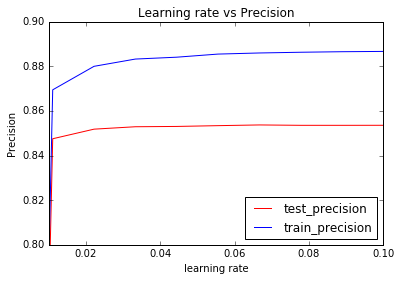

In [45]:
#Let's plot the information we got:
plt.plot(learning_rate_values,precision_test_train,color='r',label='test_precision')
plt.plot(learning_rate_values,precision_train,color='b',label='train_precision')
plt.legend(loc=4, ncol=1)
plt.axis([0.01, 0.1, 0.8, 0.9])
plt.title('Learning rate vs Precision')
plt.ylabel('Precision')
plt.xlabel('learning rate')
plt.show()

In [25]:
#We can see that the graph stabilizes approx. in the value of learning_rate=0.044, so now we fix that.

#Let's vary the window size values.
precision_test_train=[]
precision_train=[]
for i in range(len(ws_values)):
    classifier = fasttext.supervised(train_data_dir_train, 'results/model',epoch=epoch_val,lr=0.044, ws=ws_values[i] ,loss="softmax", 
                                     thread=thread_val,bucket=bucket_val)
    results=classifier.test(train_data_dir_test)
    print("Precision with a window size with value %f [test]: %f" % (ws_values[i], results.precision))
    precision_test_train.append(results.precision)
    results=classifier.test(train_data_dir_train)
    print("Precision with a window size with value %f [train]: %f" % (ws_values[i], results.precision))
    precision_train.append(results.precision)

Precision with a window size with value 1.000000 [test]: 0.853208
Precision with a window size with value 1.000000 [train]: 0.884537
Precision with a window size with value 2.000000 [test]: 0.853228
Precision with a window size with value 2.000000 [train]: 0.884635
Precision with a window size with value 3.000000 [test]: 0.853225
Precision with a window size with value 3.000000 [train]: 0.884538
Precision with a window size with value 4.000000 [test]: 0.853178
Precision with a window size with value 4.000000 [train]: 0.884678
Precision with a window size with value 5.000000 [test]: 0.853175
Precision with a window size with value 5.000000 [train]: 0.884616


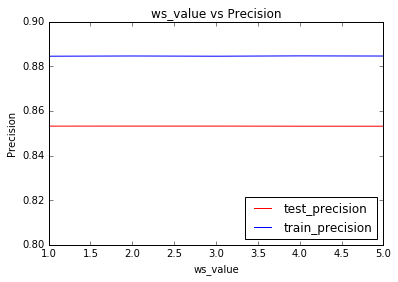

In [41]:
#Let's plot the information we got:
plt.plot(ws_values,precision_test_train,color='r',label='test_precision')
plt.plot(ws_values,precision_train,color='b',label='train_precision')
plt.legend(loc=4, ncol=1)
plt.axis([1, 5, 0.8, 0.9])
plt.title('ws_value vs Precision')
plt.ylabel('Precision')
plt.xlabel('ws_value')
plt.show()

In [35]:
#The values that we got for the window size have almost the same precision, so for a better performance for the 
#full train and test data we can choose the window size of 5.

#Let's vary now the value for the minimum word count value:

precision_test_train=[]
precision_train=[]
for i in range(len(ws_values)):
    classifier = fasttext.supervised(train_data_dir_train, 'results/model',epoch=epoch_val,lr=0.044, ws=5 ,
                                     min_count=min_count_values[i],loss="softmax",thread=thread_val,bucket=bucket_val)
    results=classifier.test(train_data_dir_test)
    print("Precision with a minimum word count with value %d [test]: %f" % (min_count_values[i], results.precision))
    precision_test_train.append(results.precision)
    results=classifier.test(train_data_dir_train)
    print("Precision with a minimum word count with value %d [train]: %f" % (min_count_values[i], results.precision))
    precision_train.append(results.precision)

Precision with a minimum word count with value 1 [test]: 0.852989
Precision with a minimum word count with value 1 [train]: 0.884592
Precision with a minimum word count with value 2 [test]: 0.851394
Precision with a minimum word count with value 2 [train]: 0.878582
Precision with a minimum word count with value 3 [test]: 0.850024
Precision with a minimum word count with value 3 [train]: 0.875532
Precision with a minimum word count with value 4 [test]: 0.849110
Precision with a minimum word count with value 4 [train]: 0.873063
Precision with a minimum word count with value 5 [test]: 0.848139
Precision with a minimum word count with value 5 [train]: 0.871226


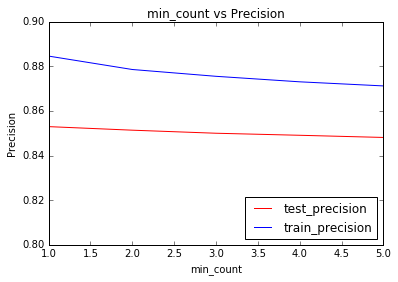

In [43]:
#Let's plot the information we got:
plt.plot(min_count_values,precision_test_train,color='r',label='test_precision')
plt.plot(min_count_values,precision_train,color='b',label='train_precision')
plt.legend(loc=4, ncol=1)
plt.axis([1, 5, 0.8, 0.9])
plt.title('min_count vs Precision')
plt.ylabel('Precision')
plt.xlabel('min_count')
plt.show()

In [48]:
#We can see that while incrementing the min_count value we obtain less precision (just a slightly difference), 
#so we select the value of min_count=3.

#Finally, we are going to vary between the different n-grams
precision_test_train=[]
precision_train=[]
for i in range(len(n_grams_values)):
    classifier = fasttext.supervised(train_data_dir_train, 'results/model',epoch=epoch_val,lr=0.044, ws=5 ,
                                     min_count=3,word_ngrams=n_grams_values[i] ,loss="softmax",thread=thread_val,bucket=bucket_val)
    results=classifier.test(train_data_dir_test)
    print("Precision with a n_gram with value %d [test]: %f" % (n_grams_values[i], results.precision))
    precision_test_train.append(results.precision)
    results=classifier.test(train_data_dir_train)
    print("Precision with a n_gram with value %d [train]: %f" % (n_grams_values[i], results.precision))
    precision_train.append(results.precision)

Precision with a n_gram with value 1 [test]: 0.850164
Precision with a n_gram with value 1 [train]: 0.875317
Precision with a n_gram with value 2 [test]: 0.865467
Precision with a n_gram with value 2 [train]: 0.913656
Precision with a n_gram with value 3 [test]: 0.867122
Precision with a n_gram with value 3 [train]: 0.918875
Precision with a n_gram with value 4 [test]: 0.867222
Precision with a n_gram with value 4 [train]: 0.919677
Precision with a n_gram with value 5 [test]: 0.866547
Precision with a n_gram with value 5 [train]: 0.919502


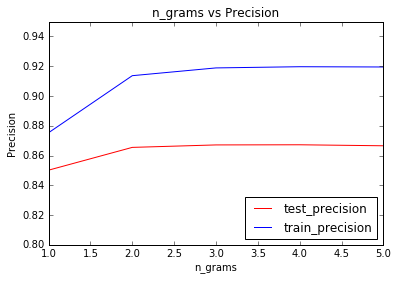

In [56]:
#Let's plot the information we got:
plt.plot(n_grams_values,precision_test_train,color='r',label='test_precision')
plt.plot(n_grams_values,precision_train,color='b',label='train_precision')
plt.legend(loc=4, ncol=1)
plt.axis([1, 5, 0.8, 0.95])
plt.title('n_grams vs Precision')
plt.ylabel('Precision')
plt.xlabel('n_grams')
plt.show()

Finally, we can see that the graph stabilizes when using bi-grams (n_grams=2), so the possible optimal values for our classifier are:
* epoch_val=5
* lr_val=0.044
* loss_val='softmax'
* ws_val=5
* min_count_val=3
* word_ngrams_val=2
* thread_val=4
* bucket_val=2000000

### Cross Validation

The following bash code prepares the data in order to perform cross validation on it (it was tested on MacOs):

From the **proc/train_data_FT.txt** file created above, we have to split between the labels and the remain text, this in order to build the k-indices for the k-fold and can perform cross validation, so after running this code, there will be two more .txt files: one with the labels and the other with the text.

```
cat proc/train_data_FT.txt | sed -e 's/ .*//' > cross_validation/cv_labels_train.txt
cat proc/train_data_FT.txt | sed -e 's/^[^ ]*//g' > cross_validation/cv_text_train.txt

```



#### Let's define some functions that we are going to use for the cross validation

In [61]:
#The next function will reconstruct the .txt files that are going to be used for creating the model with FastText

def reconstruct_txt_cross_val(training_text_cv,training_labels_cv,cv_dir):
    cv_text_train_dir="cross_validation/cv_data.txt"
    cv_labels_train_dir="cross_validation/cv_labels.txt"
    #We read the text
    with open(cv_text_train_dir, "wb") as f:
        for item in training_text_cv:
            f.write(bytes(item,'UTF-8'))
    #We read the labels
    with open(cv_labels_train_dir, "wb") as f:
        for item in training_labels_cv:
            f.write(bytes(item,'UTF-8'))
    #We concatenate both the labels and the text files so that we can file just one file with lines like the following:
    #__label__1 this is an example
    os.system("paste "+cv_labels_train_dir+" "+cv_text_train_dir+" | tr -d '\011' > "+cv_dir)

In [62]:
#This function builds the k indices for doing the cross validation
#This function is based on the function we saw in the Machine Learning course
def build_k_indices(training_labels_cv, k_fold, seed):
    #build k indices for k-fold
    num_row = training_labels_cv.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [64]:
#The following function is the cross_validation function
#This function is based on the function we saw in the Machine Learning course
def cross_validation(training_labels_cv, training_text_cv, k_indices, k):
    #Get k'th subgroup in test, others in train
    test_indices = k_indices[k]
    train_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    train_indices = train_indices.reshape(-1)
    labels_test = training_labels_cv[test_indices]
    labels_train = training_labels_cv[train_indices]
    text_test = training_text_cv[test_indices]
    text_train = training_text_cv[train_indices]
    #Reconstructing the txt files for FastText
    #Train data
    reconstruct_txt_cross_val(text_train,labels_train,"cross_validation/cv_data_train.txt")
    #Test data
    reconstruct_txt_cross_val(text_test,labels_test,"cross_validation/cv_data_test.txt")
    #Creating the FastText classifier
    classifier = fasttext.supervised("cross_validation/cv_data_train.txt",'cross_validation/model',epoch=5, 
                                     lr=0.044,loss='softmax', ws=5,min_count=3,word_ngrams=2,thread=4,bucket=2000000)
    #Calculate the precision for train and test data
    results=classifier.test("cross_validation/cv_data_train.txt")
    precision_train = results.precision
    results=classifier.test("cross_validation/cv_data_test.txt")
    precision_test = results.precision
    return precision_train, precision_test

In [65]:
#The following function is in order to perform the corresponding cross validation
#This function is based on the function we saw in the Machine Learning course
def perform_cross_validation(training_text_cv,training_labels_cv,seed,k_fold):
    # split data in k fold
    k_indices = build_k_indices(training_labels_cv, k_fold, seed)
    # define lists to store the loss of training data and test data
    precision_train = []
    precision_test = []
    # cross validation
    for k in range(k_fold):
        precision_train_k, precision_test_k = cross_validation(training_labels_cv, training_text_cv, k_indices, k)
        precision_train.append(precision_train_k)
        precision_test.append(precision_test_k)
    return precision_train,precision_test

#### Let's perform cross validation on our model with the parameters we already found

In [66]:
#Let's define the directories that were already created
train_text_cv_dir="cross_validation/cv_text_train.txt"
train_labels_cv_dir="cross_validation/cv_labels_train.txt"

#Read both the text and the labels for training, and convert them into a numpy array, this in order to make easier
#the manipulation of the indices.

with open(train_text_cv_dir, encoding="utf-8") as d:
    train_text_cv= np.array(d.readlines())
    d.close()
    
with open(train_labels_cv_dir, encoding="utf-8") as d:
    train_labels_cv = np.array(d.readlines())
    d.close()

In [69]:
#Performing cross validation with k_fold=10
precision_train_cv, precision_test_cv = perform_cross_validation(train_text_cv,train_labels_cv,seed=1,k_fold=10)

In [75]:
#Showing the precision of the train data for the 10-folds
precision_train_cv

[0.9138275265300334,
 0.9132425251672461,
 0.9137219012839746,
 0.9138445152059729,
 0.9138363901870453,
 0.9136088896570725,
 0.9136458215612888,
 0.9137174694554686,
 0.913623662418759,
 0.9134707643353033]

In [77]:
#Showing the precision of the train data for the 10-folds
precision_test_cv

[0.8678694649231853,
 0.866932133194174,
 0.8668191215672718,
 0.8669055422231381,
 0.8679824765500874,
 0.8669587241652097,
 0.8664202570017351,
 0.867543725527997,
 0.8672512248466033,
 0.8668257693100307]

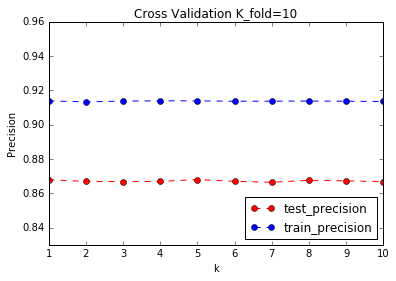

In [83]:
#Let's plot the information we got:
k_=np.linspace(1,10,10)
plt.plot(k_,precision_test_cv,marker='o', linestyle='--',color='r',label='test_precision')
plt.plot(k_,precision_train_cv,marker='o', linestyle='--',color='b',label='train_precision')
plt.legend(loc=4, ncol=1)
plt.axis([1, 10, 0.83, 0.96])
plt.title('Cross Validation K_fold=10')
plt.ylabel('Precision')
plt.xlabel('k')
plt.show()

As we can see in the cross validation graph, our results are stable, so we can rely on our model for the predictions.

### Confusion Matrix

In [112]:
#Function that plots the confusion matrix. The code is based on the one on following url:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, y_values,title,normalize=False):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(y_values))
    plt.xticks(tick_marks,y_values)
    plt.yticks(tick_marks,y_values)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],3),horizontalalignment="center",
                 color="white" if cm[i, j] >= thresh else "black",fontsize=15)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [86]:
#Let's read again, the whole training data set
train_data_dir='proc/train_data_FT.txt'
with open(train_data_dir, encoding="utf-8") as d:
    all_insta_posts = d.readlines()

In [87]:
#In order to be able to build the confusion matrix, we have to split the data, we are adjusting a ratio of 0.8 
#80% for training and 20% for testing
N = len(all_insta_posts)
ratio_train = 0.8
#Let's shuffle our train data set before the splitting
ind = random.sample(range(N),N)
ind_train=ind[1:int(N*ratio_train)+1]
ind_test = ind[int(N*ratio_train)+1:]
new_insta_posts = [all_insta_posts[e] for e in ind_train]
test_insta_posts =[all_insta_posts[e] for e in ind_test]

In [88]:
#Paths to collect splitted training data
train_data_dir_train='confusion_matrix/sp_train_data.txt'
train_data_dir_test='confusion_matrix/sp_train_data_test.txt'

#Creating the new files from splitting the train data
with open(train_data_dir_train, "wb") as f:
    for item in new_insta_posts:
         f.write(bytes(item,'UTF-8'))

with open(train_data_dir_test, "wb") as f:
    for item in test_insta_posts:
        f.write(bytes(item,'UTF-8'))

#Processing the both the train data and the train test data so that we can get both the predictions for the 
#train test data and we are also getting the actual labels of that, so that we can compare the actual label with the
#predicted one.

#Labels
os.system("cat "+train_data_dir_test+" | sed -e 's/__label__//' |  sed -e 's/ .*//' > confusion_matrix/cm_labels_test.txt")
#Text
os.system("cat "+train_data_dir_test+" | sed -e 's/^[^ ]*//g' > confusion_matrix/cm_text_test.txt")

0

In [89]:
#Let's create the model with the parameters we have found and the splitted train data
classifier = fasttext.supervised("confusion_matrix/sp_train_data.txt",'confusion_matrix/model',epoch=5, 
                                     lr=0.044,loss='softmax', ws=5,min_count=3,word_ngrams=2,thread=4,bucket=2000000)

In [90]:
#Let's read the labels and the text that we already processed two cells above, in order to make the predictions.
fin=open("confusion_matrix/cm_text_test.txt",'r')
test_data_text=fin.read().splitlines()
fin.close()

fin=open("confusion_matrix/cm_labels_test.txt",'r')
test_data_labels=fin.read().splitlines()
fin.close()

In [116]:
#Getting the number of posts
len(test_data_text)

300855

In [91]:
#Making the predictions for the test_data_text
pred_labels=classifier.predict(test_data_text)

In [100]:
#Now let's compare the predictions we got with the actual labels
count_pred=0
for i in range(len(pred_labels)):
    if pred_labels[i][0]==test_data_labels[i]:
        count_pred+=1
print("The accuracy is %0.3f%%" % (count_pred/len(pred_labels)*100))

The accuracy is 86.631%


The accuracy is not bad, but let's see how the confusion matrix looks like.

In [101]:
#Let's build the confusion matrix with both the actual labels and the predicted ones
cm = confusion_matrix(test_data_labels, pred_labels)

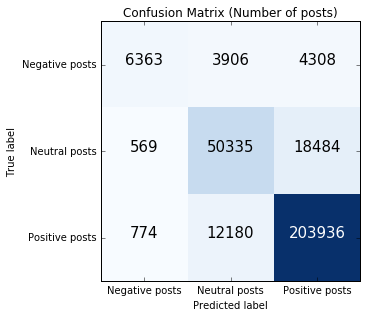

In [114]:
#Let's plot what we got
label_values=['Negative posts','Neutral posts', 'Positive posts'] 
plot_confusion_matrix(cm,label_values,title="Confusion Matrix (Number of posts)",normalize=False)

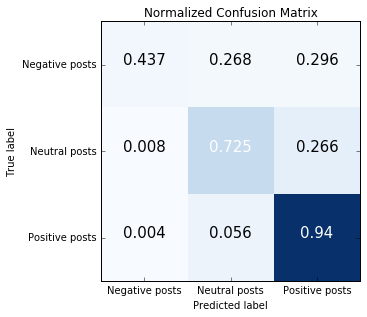

In [115]:
#Let's plot again the Confusion matrix but this time let's normalize
plot_confusion_matrix(cm,label_values,title="Normalized Confusion Matrix",normalize=True)

We can see from the normalized confusion matrix that:
* The **94% of the positive** posts were predicted correctly
* The **72.5% of the neutral** posts were predicted correctly
* The **43.7% of the negative** posts were predicted correctly

And we can see from the non-normalized confusion matrix that out of **300855**:
* **216890 posts are positive (72.09%)**
* **69388 posts are neutral (23.06%)**
* **14577 posts are negative (4.84%)**

We can see that there is a huge imbalance in the data among the different classes, especially the negative data, since it is just 4% of the total data. Despite this, we see that the neutral posts in the test data are still fairly well classified with 72.5% accuracy. While the accuracy for the negative data could be better, it is reasonable, considering that it is only 4% of the data.

### FastText code with predictions

In [162]:
#Python function for csv file creation and it will contain both the id of the instagram post and the 
#corresponding sentiment for all the predictions

def create_csv(ids, y_pred, name):
#Parameters:
#ids: a list with the tweet ids
#y_pred: a list with the probabilies of the prediction of each tweet
#name: path to output file

#Output: csv file for submission which includes all the classification labels
#1 for positive, 0 for neutral, -1 for negative
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            if r2!=[]: #Check if there is a prediction or not.
                writer.writerow({'Id':int(r1),'Prediction':r2[0]})
            else: #If not classified, then classify as neutral
                writer.writerow({'Id':int(r1),'Prediction':int(0)}) 

In [164]:
#Python script that runs FastText:

#Input files:   proc/mixed_pos_neg_labeled_FT.txt
#Output file:   results/FastText_output_probs.csv

#Path to training data
train_data_dir='proc/train_data_FT.txt'
#Path to test data 
test_data_dir='proc/test_data.txt'
test_data_ids_dir='proc/ids_test.txt'

#Defining FastText parameters with the ones that we found:
epoch_val=5
lr_val=0.044
loss_val='softmax'
ws_val=5
min_count_val=3
word_ngrams_val=2
thread_val=4
bucket_val=2000000

#Reading training data
with open(train_data_dir, encoding="utf-8") as d:
    all_insta_posts = d.readlines()

#Splitting the train data into train and test with a ratio of ratio_train in order to test the classifier locally
N = len(all_insta_posts)
ratio_train = 0.8
ind = random.sample(range(N),N)
ind_train=ind[1:int(N*ratio_train)+1]
ind_test = ind[int(N*ratio_train)+1:]
new_insta_posts = [all_insta_posts[e] for e in ind_train]
test_insta_posts =[all_insta_posts[e] for e in ind_test]

#Paths to collect splitted training data
train_data_dir_train='proc/sp_train_data_.txt'
train_data_dir_test='proc/sp_train_data_test.txt'

#Creating the new files from splitting the train data
with open(train_data_dir_train, "wb") as f:
    for item in new_insta_posts:
         f.write(bytes(item,'UTF-8'))

with open(train_data_dir_test, "wb") as f:
    for item in test_insta_posts:
        f.write(bytes(item,'UTF-8'))

#Creating the classifier with FastText with the predifined parameters
classifier = fasttext.supervised(train_data_dir_train, 'results/model',epoch=epoch_val, lr=lr_val,loss=loss_val, 
    ws=ws_val,min_count=min_count_val,word_ngrams=word_ngrams_val,thread=thread_val,bucket=bucket_val)

#Reading the test data
fin=open(test_data_dir,'r')
test_data=fin.read().splitlines()
fin.close()

print("Testing model...\n")

#Getting the local evaluation of the classifier by using the splitted test data
results=classifier.test(train_data_dir_test)
print("Precision: %f" % results.precision)

#Getting the predictions on the test data
print("Getting the predictions...\n")
pred_labels=classifier.predict(test_data)

#Counting how many predictions the classifier made
print("Counting how many predictions the classifier made:\n")
count_pos=0
count_neu=0
count_neg=0
count_no_pred=0
list_no_pred=[]

for i in range(len(pred_labels)):
    #Counting positive tweets
    if pred_labels[i]==['1']:
        count_pos+=1
    #Counting neutral tweets
    if pred_labels[i]==['0']:
        count_neu+=1
    #Counting negative tweets
    if pred_labels[i]==['-1']:
        count_neg+=1
    #Counting no predictions
    if pred_labels[i]==[]:
        count_no_pred+=1
        list_no_pred.append(i)
    
print("Positive instagram post: %d" % count_pos)
print("Negative instagram post: %d" % count_neg)
print("Neutral instagram post: %d" % count_neu)
print("Total of predictions: %d\n" %(count_pos+count_neg+ count_neu))
print("Instagram post without prediction: %d" %count_no_pred)

#Getting the tweets that don't have a prediction 
if count_no_pred>0:
    for i in range(len(list_no_pred)):
        print("%d: %s" %(list_no_pred[i]+1,test_data[list_no_pred[i]]))
        
#Generating lists for id for test data
fin=open(test_data_ids_dir,'r')
id_labels=fin.read().splitlines()
fin.close()

print("Generating file with predictions")
OUTPUT_PATH = 'results/FastText_output_preds.csv'
create_csv(id_labels, pred_labels, OUTPUT_PATH)
print("Done")


Testing model...

Precision: 0.866590
Getting the predictions...

Counting how many predictions the classifier made:

Positive instagram post: 5068112
Negative instagram post: 141795
Neutral instagram post: 1636068
Total of predictions: 6845975

Instagram post without prediction: 8
621373: bienna
621426: bienna
621486: bienna
621591: bienna
5078808: bienna laquince
5141864: bienna
5157176: bienna
6031527: unterkulm
Generating file with predictions
Done


At the end we got all the predictions for our test data set (slightly less than 7 million instagram posts). As it was expected through the analysis we have made, the majority of the predictions are positive (74%), followed by neutral (23%) and at the end, the negative (2%). There are 8 posts that couldn't be predicted (6 are the same, 1 almost the same and the last one probably a new word that was not found in the train data), by default these were taken as neutral, but one of the reasons that they weren't predicted was the fact that there is only one word per post, and if the word was never encountered in another instagram post, which have a sentiment (in the train data set), then it is impossible to be able to predict.

Finally, we got a csv file with the ids and the corresponding prediction: ***results/FastText_output_preds.csv***